## This program is to build up the CCAE+RUL research step by step ##



In [ ]:
# import used functioons 
#  import tools 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose, Concatenate
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed
from rul_features.rul_data_read import read_rul_data
from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train
from test_algs.CCAE_ntu_rul import data_augmentation
# use the first 10% data for CCAE training or filtering 

* First step: check the file status *

In [ ]:
# 開啟互動模式
%matplotlib widget

train_file_list=[]

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data'

# 測試階段只引入 1800rpm的資料

# -----------------------10psi data--------------------

collect_setting = r"Load_Free\Speed_1800\Pressure_10psi"  
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0312_V1800_10P_FREE0"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0313_V1800_10P_FREE1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0314_V1800_10P_FREE2"))

collect_setting = r"Load_1V\Speed_1800\Pressure_10psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"10kg_1V_1800rpm_1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_2"))

collect_setting = r"Load_2V\Speed_1800\Pressure_10psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0509_V1800_10P_2_1"))

# -----------------------5psi data--------------------

collect_setting = r"Load_1V\Speed_1800\Pressure_5psi"
# train_file_list.appeng(os.path.join(NTU_dataset_path, collect_setting, r"5psi_1V_1_3min"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"06kg_1V_1800rpm_2"))

collect_setting= r"Load_0V\Speed_1800\Pressure_5psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0313_V1800_5P_FREE2"))

collect_setting= r"Load_2V\Speed_1800\Pressure_5psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0402_V1800_5P_2_1"))

# 確認 train_file_list 中的所有路徑是否存在
for path in train_file_list:
    if not os.path.exists(path):
        continue
        # print(f"檔案不存在: {path}")
    else:
        print(f"檔案存在: {path}")



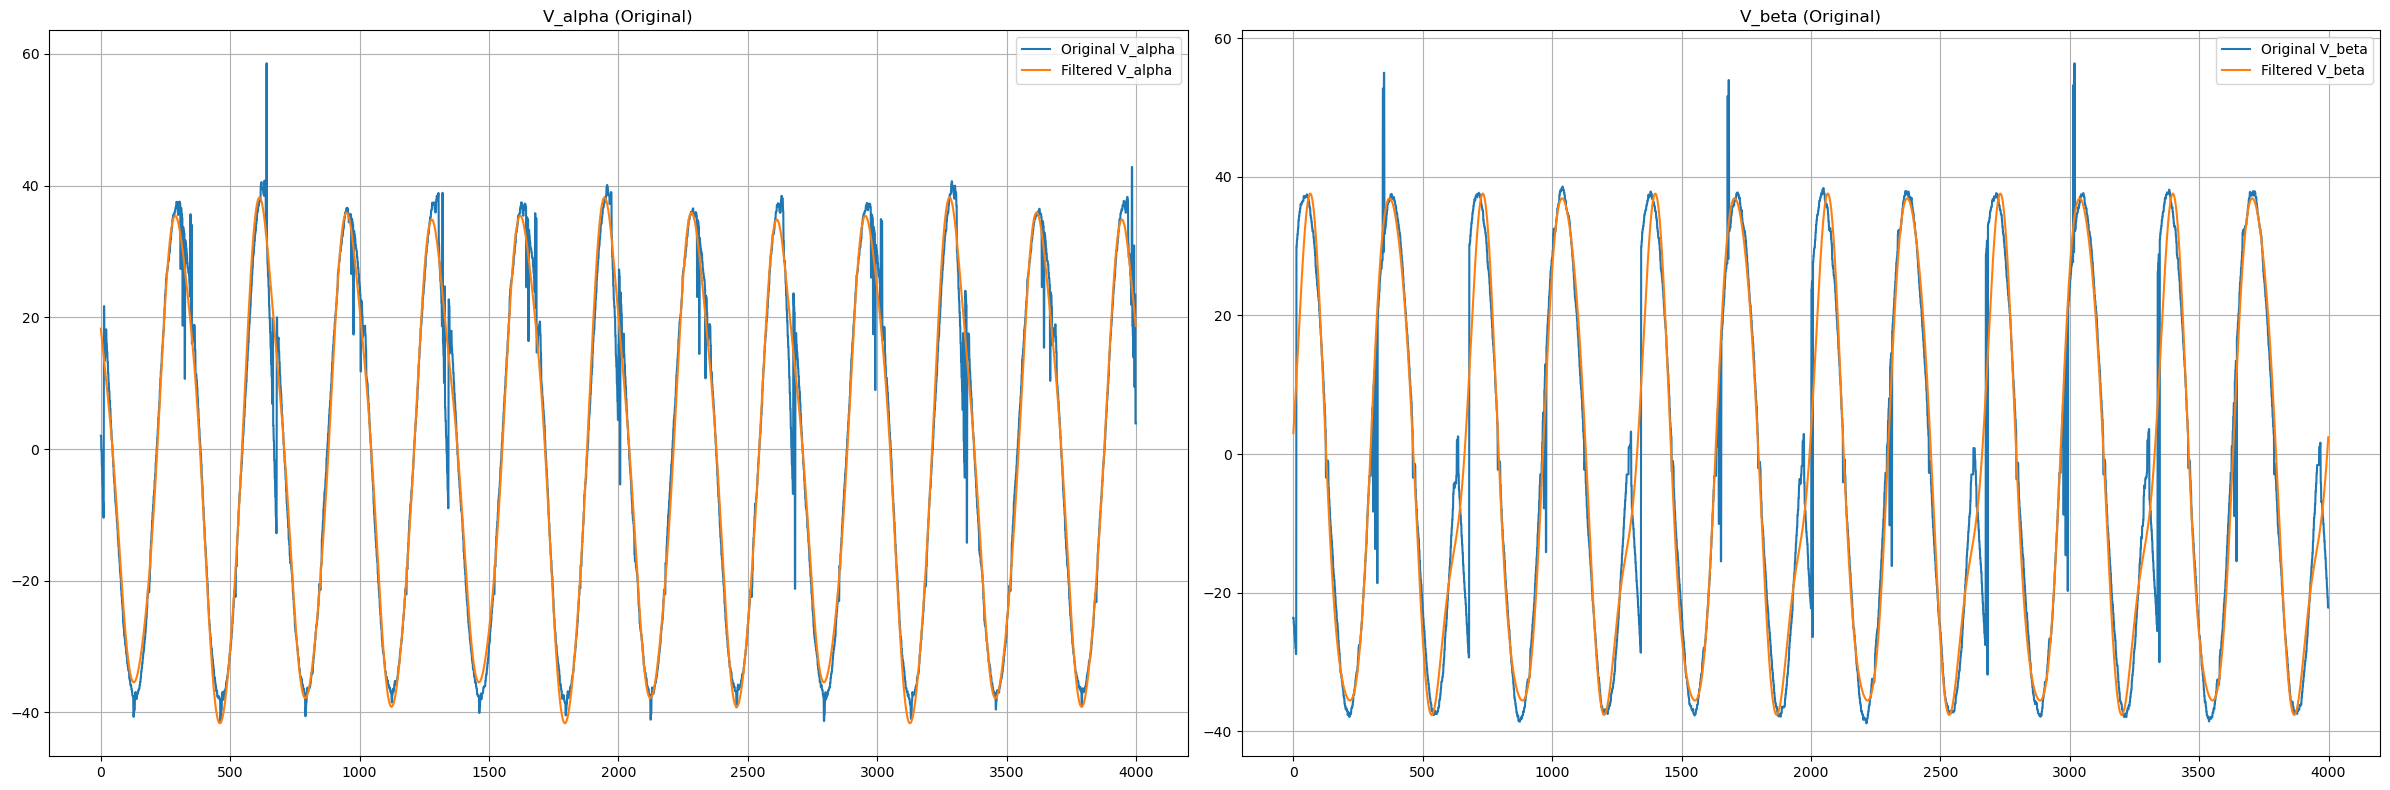

In [ ]:
def filter_top_n_frequencies(signal, n):
    """
    保留頻譜中前 n 個最大振幅的頻率分量，其餘設為 0，並還原時域訊號。
    此函式可以避免早期不穩定vsensing訊號躁聲對訊號的影響 

    Parameters:
    signal : 1D numpy array
        輸入的時域訊號。
    n : int
        要保留的最大頻率分量個數（不含DC）。

    Returns:
    filtered_signal : 1D numpy array
        經過濾波處理後的時域訊號。
    filtered_fft : 1D numpy array (complex)
        經過濾波的頻域資訊。
    """
    signal = np.squeeze(signal)
    N = len(signal)

    # FFT 及頻率
    fft_vals = np.fft.fft(signal)
    fft_mags = np.abs(fft_vals)

    # 忽略 DC 分量（index 0）來尋找最大值
    indices = np.argsort(fft_mags[1:N//2])[-n:] + 1  # +1 是因為跳過 DC

    # 建立遮罩，只保留前 n 個
    mask = np.zeros_like(fft_vals, dtype=bool)
    mask[indices] = True
    mask[-indices] = True  # 同步保留負頻率分量

    # DC 也可以選擇保留
    mask[0] = True

    # 應用遮罩
    filtered_fft = np.zeros_like(fft_vals, dtype=complex)
    filtered_fft[mask] = fft_vals[mask]

    # IFFT 還原時域訊號
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal, filtered_fft


    
rul_file_path= train_file_list[0]
files = [os.path.join(rul_file_path, f) for f in os.listdir(rul_file_path) if f.endswith(".parquet")]
files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))


df= read_rul_data(files[350])

# 取出電壓訊號 (downsample)
v_alpha = df["Voltage alpha"]
v_beta = df["Voltage beta"]

# 濾波後 (只保留前 N 個主頻)
N = 5
v_alpha_filt, _ = filter_top_n_frequencies(v_alpha, N)
v_beta_filt, _ = filter_top_n_frequencies(v_beta, N)

fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0].plot(v_alpha, label='Original V_alpha')
axs[0].plot(v_alpha_filt, label='Filtered V_alpha')
axs[0].set_title('V_alpha (Original)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(v_beta, label='Original V_beta')
axs[1].plot(v_beta_filt, label='Filtered V_beta')
axs[1].set_title('V_beta (Original)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## 模型套用參數設置 ##

In [ ]:
# 通用參數
condition_dim=1
sequence_length=1024
all_network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]


# 模組: 合併所有檔案的數據增強輸入資料，一次套用模型，然後依據每個檔案的增強數量分割結果，計算每檔案的MSE
def apply_ccae_model_to_files(rul_file_path, ccae_model, model_type, all_network_input_signal_names):
    """
    輸入:
        rul_file_path: str, RUL資料夾路徑
        ccae_model: keras model, 已訓練好的CCAE模型
        network_input_signal_names: name list, 模型輸入信號名稱
        model_type: str, 模型輸入輸出類型（例如 'V2_in_I2_out'）
    輸出:
        ccae_apply_result: dict, 包含每個檔案的MSE誤差和時間列表
    """
    files = [os.path.join(rul_file_path, f) for f in os.listdir(rul_file_path) if f.endswith(".parquet")]
    files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    all_augmented_inputs = []
    file_aug_counts = []
    file_raw_data = []

    # 先收集所有檔案的增強輸入
    for file in files:
        temp_train_input_signals = []
        df = read_rul_data(file)
        file_raw_data.append(df)
        for input_name in all_network_input_signal_names:
            raw_data = np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard
            augmented = data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented)
        # shape: (aug_num, 1024, channel)
        model_input_signals = np.stack(temp_train_input_signals, axis=2)
        all_augmented_inputs.append(model_input_signals)
        file_aug_counts.append(model_input_signals.shape[0])

    # 合併所有檔案的增強輸入資料
    all_inputs = np.concatenate(all_augmented_inputs, axis=0)  # (N_total, 1024, channel)
    
    # 準備模型輸入，針對不同模型類型進行處理
    if model_type == 'I2_in_I2_out':
        all_model_inputs = all_inputs[:, :, 2:4]              # (N_total, 1024, 2)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 2)
    if model_type == 'V2_in_I2_out':
        # 只取前兩個通道(Valpha, Vbeta) 作為輸入, (Ialpha, Ibeta) 為重建目標
         all_model_inputs = all_inputs[:, :, :2]  # (N_total, 1024, 2)
         all_verify_data = all_inputs[:, :, 2:4]  # (N_total, 1024, 2)
    elif model_type == 'V2I2_in_V2I2_out':
        # 保留四個通道作為輸入
        all_model_inputs = all_inputs              # (N_total, 1024, 4)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 4)
    # 分解輸入訊號至多個單通道輸入       
    split_input_list = [all_model_inputs[:, :, i:i+1] for i in range(all_model_inputs.shape[2])]
    split_input_list.append(np.ones((all_model_inputs.shape[0], 1)))  # 條件輸入

    # 分批進行模型推論以避免 OOM
    batch_size = 2048
    total_samples = split_input_list[0].shape[0]
    results = [np.empty_like(split_input_list[i]) for i in range(len(split_input_list)-1)]  # 預先建立空陣列存放結果
    for start in range(0, total_samples, batch_size):
        end = min(start + batch_size, total_samples)
        batch_inputs = [x[start:end] for x in split_input_list]
        batch_results = ccae_model.predict(batch_inputs, batch_size=batch_size)
        # 若模型只有一個輸出，batch_results 不是 list
        if not isinstance(batch_results, list):
            batch_results = [batch_results]
        for i, r in enumerate(batch_results):
            results[i][start:end] = r
    results = results  # list, 每個 output shape = (N_total, 1024, 1)

    # 依據每個檔案的增強數量分割結果，計算每檔案的MSE
    mse_errors_by_file = []
    start_idx = 0
    for file_idx, aug_num in enumerate(file_aug_counts):
        end_idx = start_idx + aug_num
        # 取出該檔案的輸入與重建結果
        input_this_file = all_verify_data[start_idx:end_idx]  # (aug_num, 1024, channel)
        recon_this_file = [r[start_idx:end_idx] for r in results]  # list of (aug_num, 1024, 1)
        recon_this_file = np.concatenate(recon_this_file, axis=2)  # (aug_num, 1024, channel)
        # 計算每個增強片段的MSE，然後平均
        mse = np.mean((input_this_file - recon_this_file) ** 2, axis=(1,2))  # (aug_num,)
        mse_avg = np.mean(mse)
        mse_errors_by_file.append(mse_avg)
        start_idx = end_idx

    ccae_apply_result = {
        "model_type": model_type,
        "file_path": rul_file_path,
        "file_list": files,
        "augment_counts": file_aug_counts,
        "mse_avg_byfile": mse_errors_by_file,
    }
    return ccae_apply_result,all_inputs, results



In [ ]:
def estimate_torque(data_read, speed_v=1800, debug=False):

    """
    Estimate the motor torque based on voltage and current inputs.
    :param v_a_raw: Voltage alpha component
    :param v_b_raw: Voltage beta component
    :param i_alpha: Current alpha component
    :param i_beta: Current beta component
    :param speed_v: Motor speed in rpm (default: 900)
    :param debug: Boolean flag to enable debugging plots (default: False)
    :return: Estimated torque array
    """

    v_a_raw = np.array(data_read["Voltage alpha downsample"])
    v_c_raw = np.array(data_read["Voltage beta downsample"])
    i_alpha = np.array(data_read["Current alpha downsample"])
    i_beta  = np.array(data_read["Current beta downsample"])

    # offset calibration
    v_a_raw = v_a_raw - np.mean(v_a_raw)
    v_c_raw = v_c_raw - np.mean(v_c_raw)
    i_alpha = i_alpha - np.mean(i_alpha)
    i_beta = i_beta - np.mean(i_beta)

    # Preprocess the voltage data, transform the data to alpha-beta frame
    v_alpha = v_a_raw
    v_beta = v_c_raw
    
    class EMF:
        def __init__(self):
            self.Alpha = 0.0
            self.Beta = 0.0
            self.Alpha_last = 0.0
            self.Beta_last = 0.0
            self.Alpha_LPF = 0.0
            self.Beta_LPF = 0.0
            self.Alpha_LPF_last = 0.0
            self.Beta_LPF_last = 0.0

    def emf_to_lpf(sampling_time, lpf_radius, emf_obj):
        lpf_radius_t = lpf_radius * sampling_time
        emf_coef1 = sampling_time / (lpf_radius_t + 2)
        emf_coef2 = (lpf_radius_t - 2) / (lpf_radius_t + 2)

        emf_obj.Alpha_LPF = emf_coef1 * (emf_obj.Alpha_last + emf_obj.Alpha) - emf_coef2 * emf_obj.Alpha_LPF_last
        emf_obj.Beta_LPF = emf_coef1 * (emf_obj.Beta_last + emf_obj.Beta) - emf_coef2 * emf_obj.Beta_LPF_last

        emf_obj.Alpha_last = emf_obj.Alpha
        emf_obj.Beta_last = emf_obj.Beta

        emf_obj.Alpha_LPF_last = emf_obj.Alpha_LPF
        emf_obj.Beta_LPF_last = emf_obj.Beta_LPF

    def flux_comp(omega_e, lpf_radius):
        if np.abs(omega_e) < 1:
            mag_comp = 1.0
        else:
            mag_comp = np.abs(omega_e) / np.sqrt(omega_e ** 2 + lpf_radius ** 2)

        phase_comp = -57.29578 * np.arctan2(lpf_radius, omega_e) / 360  # Degree to radians conversion

        return mag_comp, phase_comp

    # Compute necessary parameters
    fs = 20000 # Sampling rate
    flux_rs = 12.5  # Motor stator resistance
    tsim = 1 / fs  # Time step

    we = (speed_v / 60) * (np.pi * 2)*4 # electrical angular velocity
    coef = 0.2
    cross_freq = 15.0

    intgr_bw_f = max((we / (np.pi * 2)) * coef, cross_freq)
    fast_wc = intgr_bw_f * (np.pi * 2)

    # Process each time step
    emf1 = EMF()
    alpha_lpf_values, beta_lpf_values = [], []
    alpha_raw_values, beta_raw_values = [], []

    for va, vb, ia, ib in zip(v_alpha, v_beta, i_alpha, i_beta):
        emf1.Alpha = va - (ia * flux_rs)
        emf1.Beta = vb - (ib * flux_rs)
        alpha_raw_values.append(emf1.Alpha)
        beta_raw_values.append(emf1.Beta)
        emf_to_lpf(tsim, fast_wc, emf1)
        alpha_lpf_values.append(emf1.Alpha_LPF)
        beta_lpf_values.append(emf1.Beta_LPF)

    # Flux compensation
    mag_comp2, phase_comp2 = flux_comp(we, fast_wc)

    # Apply phase and magnitude compensation
    alpha_compensated_values, beta_compensated_values = [], []
    for alpha, beta in zip(alpha_lpf_values, beta_lpf_values):
        ds = alpha * mag_comp2
        qs = beta * mag_comp2
        angle = phase_comp2
        sine, cosine = np.sin(angle), np.cos(angle)
        alpha_transformed = ds * cosine - qs * sine
        beta_transformed = qs * cosine + ds * sine
        alpha_compensated_values.append(alpha_transformed)
        beta_compensated_values.append(beta_transformed)

    # Torque estimation
    torque_v = 1.5 * 4 * ((np.array(alpha_compensated_values) * i_beta) - (np.array(beta_compensated_values) * i_alpha))
    torque_avg = np.mean(np.abs(torque_v[-500:]))
    # Power and efficiency estimation
    Power_M= torque_avg*speed_v*2*np.pi/60
    Power_E = 1.5*np.mean((v_alpha * i_alpha + v_beta * i_beta))
    efficiency = Power_M / Power_E * 100
    power_sts = {
        'Power_M': Power_M,
        'Power_E': Power_E,
        'Efficiency': efficiency,
        'Efficiency_alarm': int(efficiency < 90)
    }

    if debug :
        date_time=pd.to_datetime(data_read["Unix Time"], unit='s').strftime('%Y-%m-%d %H:%M:%S')

        print("Estimated Torque:", np.mean(torque_v[-500:]))
        # print result
        for key, value in power_sts.items():
            print(f"{key}: {value}")
        time = np.arange(len(v_alpha)) * tsim

        # plot the flux values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_compensated_values, label='Flux Alpha')
        plt.plot(time, beta_compensated_values, label='Flux Beta ')
        plt.xlabel('Time (s)')
        plt.ylabel('Flux Values')
        plt.legend()
        plt.title('Flux Values'+date_time)
        plt.grid()
        plt.show(block=False)

        # plot the voltage values
        plt.figure(figsize=(10, 5))
        plt.plot(time, v_alpha, label='Voltage Beta (raw)')
        plt.plot(time, v_beta, label='Voltage Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage Values')
        plt.legend()
        plt.title('Voltage Values')
        plt.grid()
        plt.show(block=False)

        # plot the current values
        plt.figure(figsize=(10, 5))
        plt.plot(time, i_alpha, label='Current Alpha (raw)')
        plt.plot(time, i_beta, label='Current Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Current Values')
        plt.legend()
        plt.title('Current Values')
        plt.grid()
        plt.show(block=False)

        # plot the EMF values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_raw_values, label='EMF Alpha (raw)')
        plt.plot(time, beta_raw_values, label='EMF Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('EMF Values')
        plt.legend()
        plt.title('EMF Values')
        plt.grid()
        plt.show(block=False)

        # plot torque estimation
        plt.figure(figsize=(10, 5))
        plt.plot(time, torque_v, label='Torque (Voltage Model)')
        if len(torque_v) > 2500:
            plt.plot(time[2250:2500], torque_v[2250:2500], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[2250:2500])
        else:
            plt.plot(time[-500:], torque_v[-500:], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[-500:])
            
        plt.axhline(y=torque_avg, color='k', linestyle='--', label='Averaged torque')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (N.m)')
        plt.legend()
        plt.title(f'Torque Estimation :{torque_avg:.2f} (N.m)')
        plt.grid()
        plt.show(block=False)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('EMF Alpha (Raw)', color='tab:blue')
        ax1.plot(time, alpha_raw_values, label='EMF Alpha (Raw)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMF Alpha (Filtered)', color='tab:red')
        # ax2.plot(time, alpha_lpf_values, label='EMF Alpha (Filtered)', color='tab:red')
        ax2.plot(time, alpha_compensated_values, label='EMF Alpha (Compensated)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title('EMF Alpha - Raw vs Filtered')
        plt.grid()
        plt.show(block=False)
    # return the torque value and the estimated flux
    return torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts



fig, ax1 = plt.subplots(figsize=(12, 6))

first_file = os.listdir(train_file_list[0])
first_file = [f for f in first_file if f.endswith('.parquet')]
first_file.sort(key=lambda f: int(os.path.splitext(f)[0].split('_')[-1]))
first_file_path = os.path.join(train_file_list[0], first_file[0])
df = read_rul_data(first_file_path)

# 取原始 downsample 資料
v_alpha = df["Voltage alpha"]
v_beta = df["Voltage beta"]
i_alpha = df["Current alpha"]
i_beta = df["Current beta"]

# 畫電壓
color_v1 = 'tab:blue'
color_v2 = 'tab:cyan'
ax1.set_xlabel("Sample Index")
ax1.set_ylabel("Voltage", color=color_v1)
ax1.plot(v_alpha, label="Voltage alpha downsample", color=color_v1)
ax1.plot(v_beta, label="Voltage beta downsample", color=color_v2)
ax1.tick_params(axis='y', labelcolor=color_v1)
ax1.legend(loc='upper left')
ax1.grid(True)

# 畫電流
ax2 = ax1.twinx()
color_i1 = 'tab:red'
color_i2 = 'tab:orange'
ax2.set_ylabel("Current", color=color_i1)
ax2.plot(i_alpha, label="Current alpha downsample", color=color_i1)
ax2.plot(i_beta, label="Current beta downsample", color=color_i2)
ax2.tick_params(axis='y', labelcolor=color_i1)
ax2.legend(loc='upper right')

plt.title("Downsampled Voltage and Current (First File)")
plt.tight_layout()
plt.show()

estimate_torque(df, speed_v=1800, debug=True)

## 先取I -> I 模型 ##

In [ ]:

model_type='I2_in_I2_out'
network_input_signal_names=["Current alpha downsample", "Current beta downsample"]
network_train_output_names=["Current alpha downsample", "Current beta downsample"]

model_folder_path='NTU_rul_models'
model_name = f'CCAE_{model_type}.keras'
model_file_path = os.path.join(model_folder_path, "models", model_name)
my_ccae_model_trained=load_model(model_file_path)

ccae_result, all_inputs, results = apply_ccae_model_to_files(train_file_list[0], my_ccae_model_trained, model_type, all_network_input_signal_names)
I2_in_I2_out_apply_result = {
    "model_type": model_type,
    "network_input_signal_names": network_input_signal_names,
    "network_train_output_names": network_train_output_names,
    "file_path": ccae_result["file_path"],
    "file_list": ccae_result["file_list"],
    "augment_counts": ccae_result["augment_counts"],
    "mse_avg_byfile": ccae_result["mse_avg_byfile"],
    "all_inputs": all_inputs,
    "recon_results": results
}


## 再取V -> I 模型 ##

In [ ]:

model_type='V2_in_I2_out'
network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample"]
network_train_output_names=["Current alpha downsample", "Current beta downsample"]

model_folder_path='NTU_rul_models'
model_name = f'CCAE_{model_type}.keras'
model_file_path = os.path.join(model_folder_path, "models", model_name)
my_ccae_model_trained=load_model(model_file_path)

ccae_result, all_inputs, results = apply_ccae_model_to_files(train_file_list[0], my_ccae_model_trained, model_type, all_network_input_signal_names)
V2_in_I2_out_apply_result = {
    "model_type": model_type,
    "network_input_signal_names": network_input_signal_names,
    "network_train_output_names": network_train_output_names,
    "file_path": ccae_result["file_path"],
    "file_list": ccae_result["file_list"],
    "augment_counts": ccae_result["augment_counts"],
    "mse_avg_byfile": ccae_result["mse_avg_byfile"],
    "all_inputs": all_inputs,
    "recon_results": results
}


## 再取VI -> VI 模型 ##

In [ ]:
import os

model_folder_path='NTU_rul_models' 
model_dir = os.path.join(model_folder_path, "models")
model_files = os.listdir(model_dir)
print("All files in model directory:")
for f in model_files:
    print(f)
print(model_file_path)

print(os.path.exists(r"NTU_rul_models\models\CCAE_V2I2_in_V2I2_out.keras"))  # 應該要顯示 True

In [ ]:

model_type='V2I2_in_V2I2_out'
# model_type='V2_in_I2_out'
network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
network_train_output_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]

model_folder_path='NTU_rul_models'
model_name = f'CCAE_{model_type}.keras'
# model_file_path = os.path.join(model_folder_path, "models", model_name)
model_file_path = r"NTU_rul_models\models\CCAE_V2I2_in_V2I2_out.keras"

my_ccae_model_trained=load_model(model_file_path)

ccae_result, all_inputs, results = apply_ccae_model_to_files(train_file_list[0], my_ccae_model_trained, model_type, all_network_input_signal_names)
V2I2_in_V2I2_out_apply_result = {
    "model_type": model_type,
    "network_input_signal_names": network_input_signal_names,
    "network_train_output_names": network_train_output_names,
    "file_path": ccae_result["file_path"],
    "file_list": ccae_result["file_list"],
    "augment_counts": ccae_result["augment_counts"],
    "mse_avg_byfile": ccae_result["mse_avg_byfile"],
    "all_inputs": all_inputs,
    "recon_results": results
}


In [48]:
train_file_list[0]

'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Organized_Data\\Load_Free\\Speed_1800\\Pressure_10psi\\0312_V1800_10P_FREE0'

## 比較兩者 ##

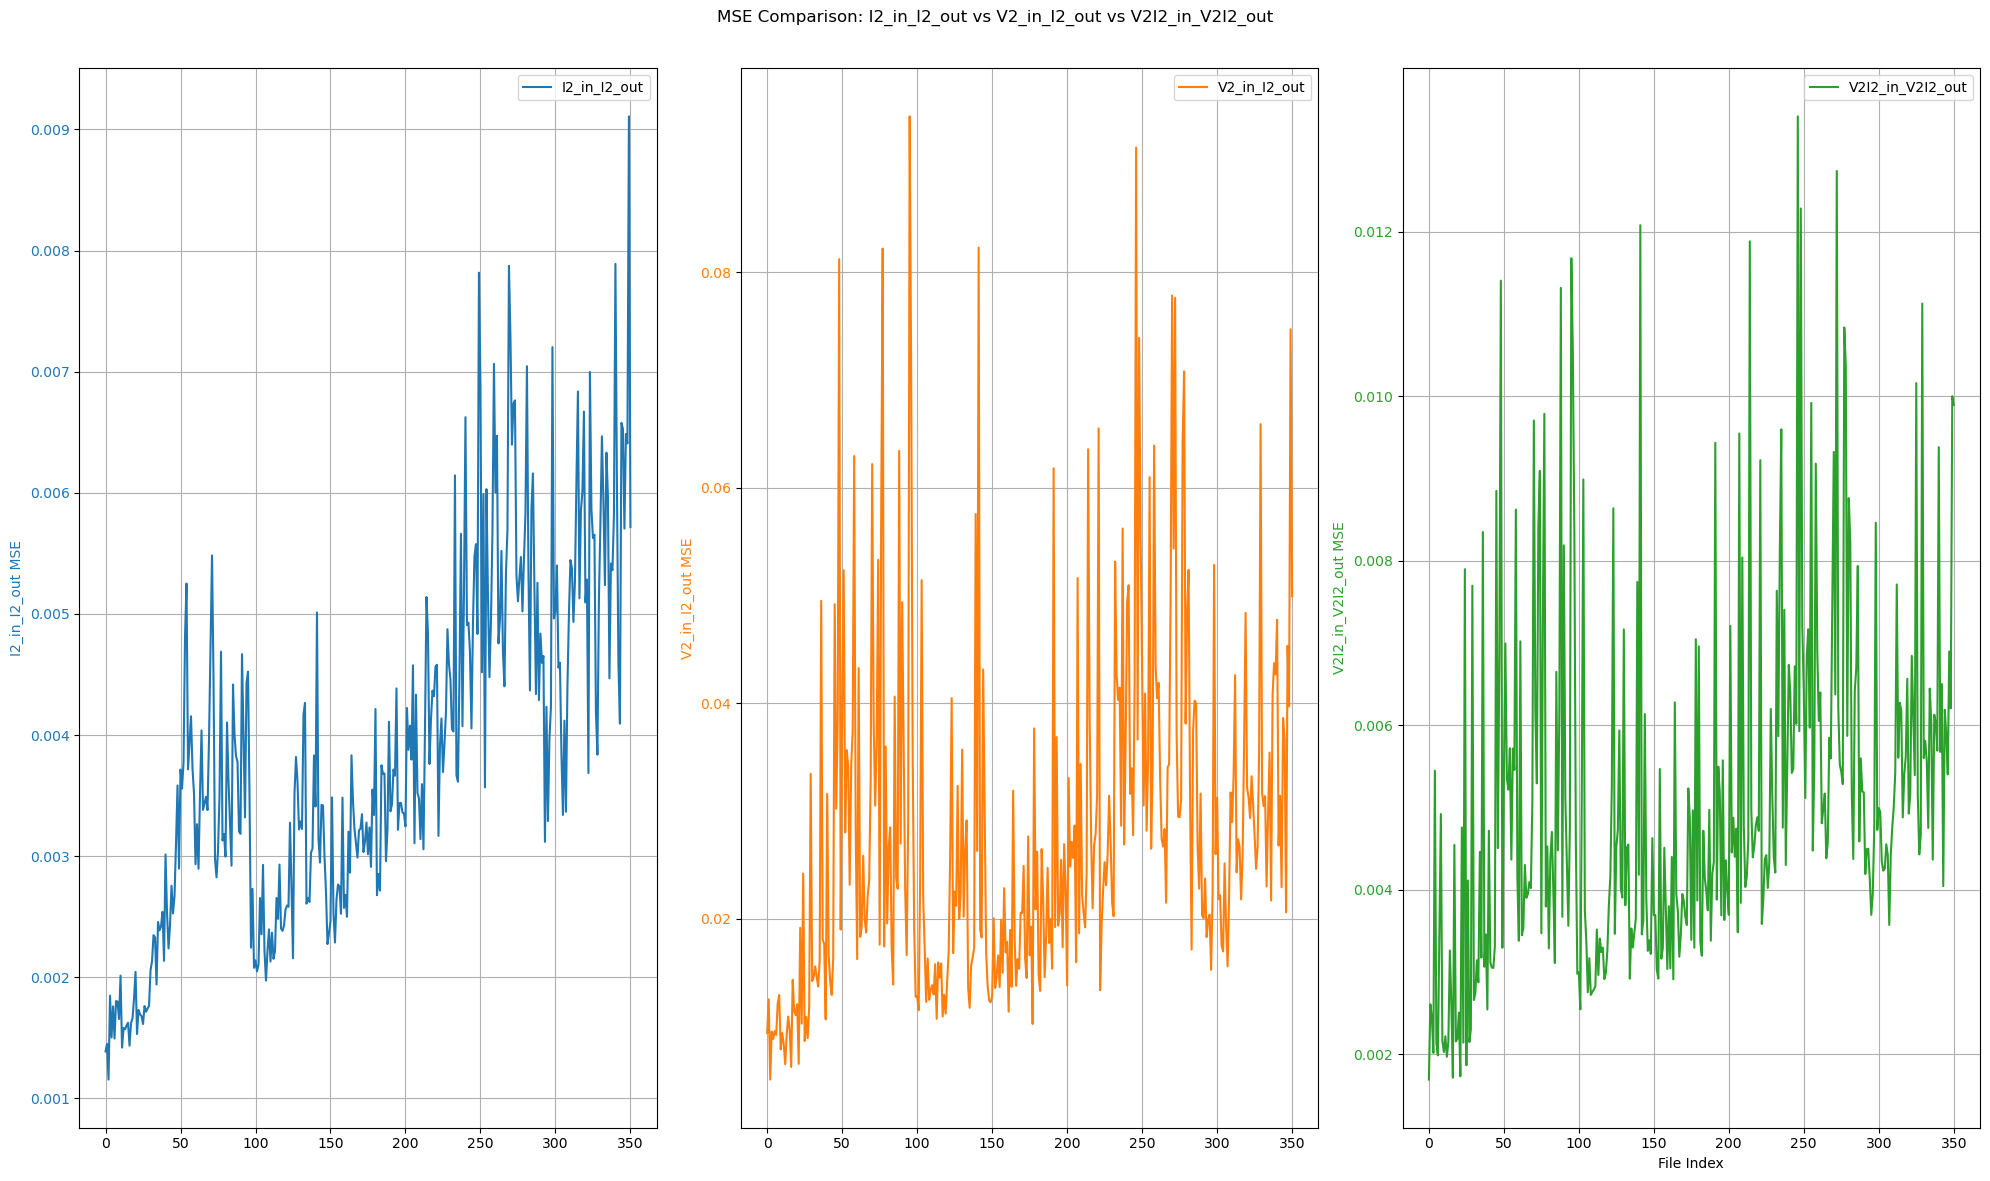

In [40]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharex=True)

color1 = 'tab:blue'
color2 = 'tab:orange'
color3 = 'tab:green'

# I2_in_I2_out
axs[0].plot(range(len(I2_in_I2_out_apply_result['mse_avg_byfile'])), I2_in_I2_out_apply_result['mse_avg_byfile'], label='I2_in_I2_out', color=color1)
axs[0].set_ylabel('I2_in_I2_out MSE', color=color1)
axs[0].tick_params(axis='y', labelcolor=color1)
axs[0].legend()
axs[0].grid(True)

# V2_in_I2_out
axs[1].plot(range(len(V2_in_I2_out_apply_result['mse_avg_byfile'])), V2_in_I2_out_apply_result['mse_avg_byfile'], label='V2_in_I2_out', color=color2)
axs[1].set_ylabel('V2_in_I2_out MSE', color=color2)
axs[1].tick_params(axis='y', labelcolor=color2)
axs[1].legend()
axs[1].grid(True)

# V2I2_in_V2I2_out
if 'V2I2_in_V2I2_out_apply_result' in locals():
    axs[2].plot(range(len(V2I2_in_V2I2_out_apply_result['mse_avg_byfile'])), V2I2_in_V2I2_out_apply_result['mse_avg_byfile'], label='V2I2_in_V2I2_out', color=color3)
else:
    axs[2].plot([], [], label='V2I2_in_V2I2_out', color=color3)  # empty if not present
axs[2].set_ylabel('V2I2_in_V2I2_out MSE', color=color3)
axs[2].tick_params(axis='y', labelcolor=color3)
axs[2].set_xlabel('File Index')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('MSE Comparison: I2_in_I2_out vs V2_in_I2_out vs V2I2_in_V2I2_out')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



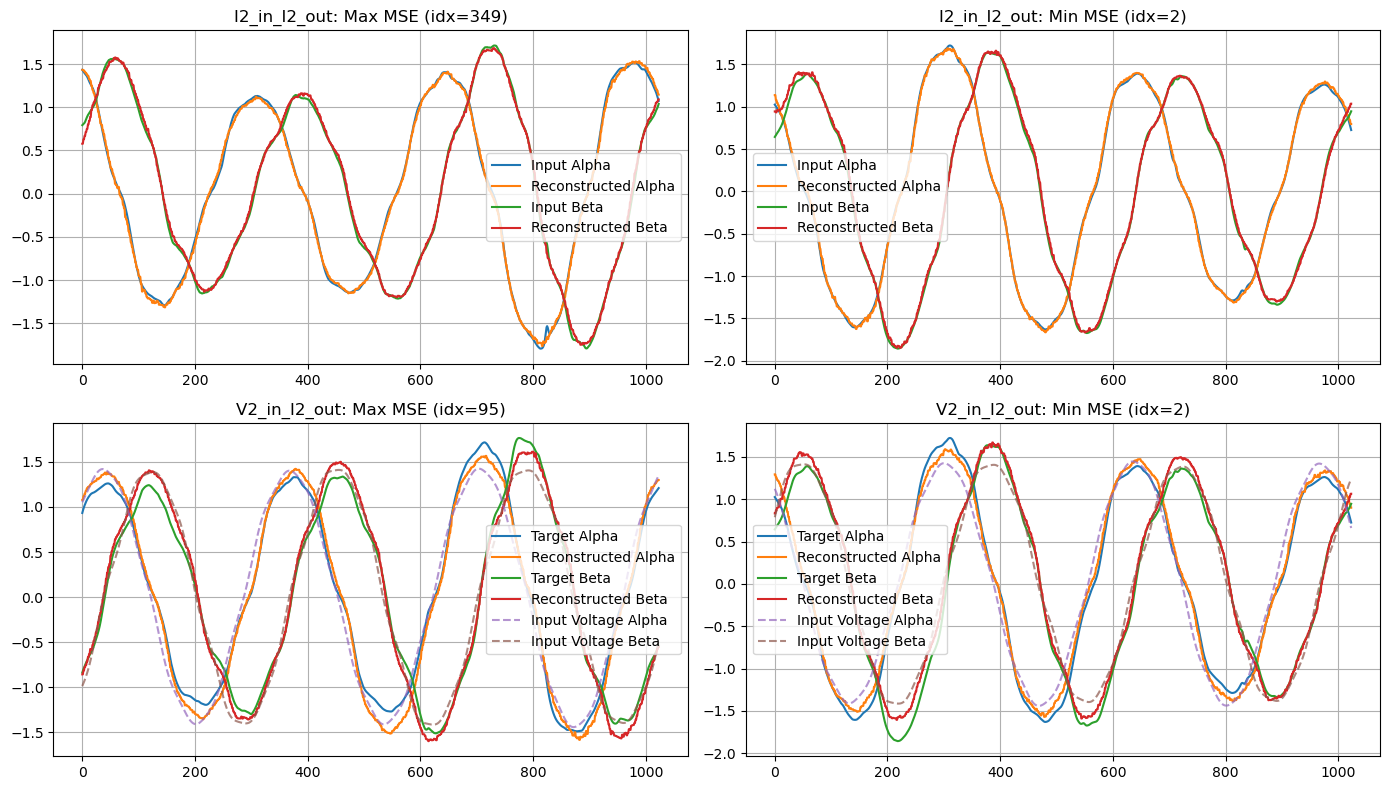

In [46]:
fig2, axs = plt.subplots(2, 2, figsize=(14, 8))

# 找到 I2_in_I2_out mse 最大與最小的 index
mse_i2 = np.array(I2_in_I2_out_apply_result['mse_avg_byfile'])
idx_max_i2 = np.argmax(mse_i2)
idx_min_i2 = np.argmin(mse_i2)

# 找到 V2_in_I2_out mse 最大與最小的 index
mse_v2 = np.array(V2_in_I2_out_apply_result['mse_avg_byfile'])
idx_max_v2 = np.argmax(mse_v2)
idx_min_v2 = np.argmin(mse_v2)

# I2_in_I2_out: mse 最大與最小的 input/output
input_i2_max = I2_in_I2_out_apply_result['all_inputs'][idx_max_i2:idx_max_i2+1, :, 2:4]
input_i2_min = I2_in_I2_out_apply_result['all_inputs'][idx_min_i2:idx_min_i2+1, :, 2:4]
recon_i2_max = [r[idx_max_i2:idx_max_i2+1] for r in I2_in_I2_out_apply_result['recon_results']]
recon_i2_min = [r[idx_min_i2:idx_min_i2+1] for r in I2_in_I2_out_apply_result['recon_results']]

# V2_in_I2_out: mse 最大與最小的 input/output
input_v2_max = V2_in_I2_out_apply_result['all_inputs'][idx_max_v2:idx_max_v2+1, :, :2]
input_v2_min = V2_in_I2_out_apply_result['all_inputs'][idx_min_v2:idx_min_v2+1, :, :2]
recon_v2_max = [r[idx_max_v2:idx_max_v2+1] for r in V2_in_I2_out_apply_result['recon_results']]
recon_v2_min = [r[idx_min_v2:idx_min_v2+1] for r in V2_in_I2_out_apply_result['recon_results']]
target_i_v2_max = V2_in_I2_out_apply_result['all_inputs'][idx_max_v2:idx_max_v2+1, :, 2:4]
target_i_v2_min = V2_in_I2_out_apply_result['all_inputs'][idx_min_v2:idx_min_v2+1, :, 2:4]

# 1. I2_in_I2_out - mse 最大
axs[0, 0].plot(input_i2_max[0, :, 0], label='Input Alpha')
axs[0, 0].plot(np.squeeze(recon_i2_max[0][0]), label='Reconstructed Alpha')
axs[0, 0].plot(input_i2_max[0, :, 1], label='Input Beta')
axs[0, 0].plot(np.squeeze(recon_i2_max[1][0]), label='Reconstructed Beta')
axs[0, 0].set_title(f'I2_in_I2_out: Max MSE (idx={idx_max_i2})')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. I2_in_I2_out - mse 最小
axs[0, 1].plot(input_i2_min[0, :, 0], label='Input Alpha')
axs[0, 1].plot(np.squeeze(recon_i2_min[0][0]), label='Reconstructed Alpha')
axs[0, 1].plot(input_i2_min[0, :, 1], label='Input Beta')
axs[0, 1].plot(np.squeeze(recon_i2_min[1][0]), label='Reconstructed Beta')
axs[0, 1].set_title(f'I2_in_I2_out: Min MSE (idx={idx_min_i2})')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. V2_in_I2_out - mse 最大
axs[1, 0].plot(target_i_v2_max[0, :, 0], label='Target Alpha')
axs[1, 0].plot(np.squeeze(recon_v2_max[0][0]), label='Reconstructed Alpha')
axs[1, 0].plot(target_i_v2_max[0, :, 1], label='Target Beta')
axs[1, 0].plot(np.squeeze(recon_v2_max[1][0]), label='Reconstructed Beta')
axs[1, 0].plot(input_v2_max[0, :, 0], label='Input Voltage Alpha', linestyle='--', alpha=0.7)
axs[1, 0].plot(input_v2_max[0, :, 1], label='Input Voltage Beta', linestyle='--', alpha=0.7)
axs[1, 0].set_title(f'V2_in_I2_out: Max MSE (idx={idx_max_v2})')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. V2_in_I2_out - mse 最小
axs[1, 1].plot(target_i_v2_min[0, :, 0], label='Target Alpha')
axs[1, 1].plot(np.squeeze(recon_v2_min[0][0]), label='Reconstructed Alpha')
axs[1, 1].plot(target_i_v2_min[0, :, 1], label='Target Beta')
axs[1, 1].plot(np.squeeze(recon_v2_min[1][0]), label='Reconstructed Beta')
axs[1, 1].plot(input_v2_min[0, :, 0], label='Input Voltage Alpha', linestyle='--', alpha=0.7)
axs[1, 1].plot(input_v2_min[0, :, 1], label='Input Voltage Beta', linestyle='--', alpha=0.7)
axs[1, 1].set_title(f'V2_in_I2_out: Min MSE (idx={idx_min_v2})')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# model_type='I2_in_I2_out'
# model_type='V2_in_I2_out'
# model_type='V2I2_in_V2I2_out'
if model_type == 'I2_in_I2_out':
    network_input_signal_names=["Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
    input_dim_list = [1, 1]
if model_type == 'V2_in_I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
    input_dim_list = [1, 1]
if model_type == 'V2I2_in_V2I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample", "Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    input_dim_list = [1, 1, 1, 1]   # quadra phase input, quadra phase output

all_network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]

condition_dim=1
sequence_length=1024
model_folder_path='NTU_rul_models'
model_name = f'CCAE_{model_type}.keras'
model_file_path = os.path.join(model_folder_path, "models", model_name)
my_ccae_model_trained=load_model(model_file_path)


train_factor=0.1  # 訓練資料比例(前10%資料)
initial_files = []
initial_datalist=[]
train_input_signals=[]
train_output_signals=[]

for file_path in train_file_list:
    if os.path.exists(file_path):

        # load and sort the files in path 
        files = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(".parquet")] 
        files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))
        
        # Use only first 10% of files for training 
        num_files = max(int(len(files) * train_factor),1)
        
        #對每個測試資料夾取出訓練資料
        for i in range(num_files):
            # read the data
            df = read_rul_data(files[i])
            if len(df[network_input_signal_names[0]])<2000:
                print('incorrect data length, please check the file: \n', files[i])
                print('raw data length: ', len(df["Voltage alpha"]))
                continue
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_input_signals = []
            for input_name in all_network_input_signal_names:
            # normalization
                raw_data=np.array(df[input_name])
                mean = np.mean(raw_data)
                standard = np.std(raw_data)
                normalized = (raw_data - mean) / standard  # 轉成 (1024, 1)
                augmented_data= data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
                temp_train_input_signals.append(augmented_data) # normalization
                
                # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
                
            # 加入 train_input_s
            # ignals
            train_input_signals.append(np.stack(temp_train_input_signals, axis=2))            
    else:
        print(f"File {file_path} does not exist.")
# 將所有訓練資料合併成一個大矩陣 (N_total, 1024, dim)
train_input_signals = np.concatenate(train_input_signals,axis=0)
print(f"train_input_signals shape: {train_input_signals.shape}")
        

In [ ]:
# --------------------模型應用---------------------
# 合併所有檔案的數據增強輸入資料，一次套用模型，然後依據每個檔案的增強數量分割結果，計算每檔案的MSE

def apply_ccae_model_to_files_v2(rul_file_path, ccae_model, model_type, network_input_signal_names):
    """
    輸入:
        rul_file_path: str, RUL資料夾路徑
        ccae_model: keras model, 已訓練好的CCAE模型
        network_input_signal_names: name list, 模型輸入信號名稱
        model_type: str, 模型輸入輸出類型（例如 'V2_in_I2_out'）
    輸出:
        ccae_apply_result: dict, 包含每個檔案的MSE誤差和時間列表
    """
    files = [os.path.join(rul_file_path, f) for f in os.listdir(rul_file_path) if f.endswith(".parquet")]
    files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    all_augmented_inputs = []
    file_aug_counts = []
    file_raw_data = []

    # 先收集所有檔案的增強輸入
    for file in files:
        temp_train_input_signals = []
        df = read_rul_data(file)
        file_raw_data.append(df)
        for input_name in network_input_signal_names:
            raw_data = np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard
            augmented = data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented)
        # shape: (aug_num, 1024, channel)
        model_input_signals = np.stack(temp_train_input_signals, axis=2)
        all_augmented_inputs.append(model_input_signals)
        file_aug_counts.append(model_input_signals.shape[0])

    # 合併所有檔案的增強輸入資料
    all_inputs = np.concatenate(all_augmented_inputs, axis=0)  # (N_total, 1024, channel)
    
    # 準備模型輸入，針對不同模型類型進行處理
    if model_type == 'I2_in_I2_out':
        all_model_inputs = all_inputs              # (N_total, 1024, 2)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 2)
    if model_type == 'V2_in_I2_out':
        # 只取前兩個通道(Valpha, Vbeta) 作為輸入, (Ialpha, Ibeta) 為重建目標
         all_model_inputs = all_inputs[:, :, :2]  # (N_total, 1024, 2)
         all_verify_data = all_inputs[:, :, 2:4]  # (N_total, 1024, 2)
    elif model_type == 'V2I2_in_V2I2_out':
        # 保留四個通道作為輸入
        all_model_inputs = all_inputs              # (N_total, 1024, 4)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 4)
    # 分解輸入訊號至多個單通道輸入       
    split_input_list = [all_model_inputs[:, :, i:i+1] for i in range(all_model_inputs.shape[2])]
    split_input_list.append(np.ones((all_model_inputs.shape[0], 1)))  # 條件輸入

    # 一次性模型推論
    results = ccae_model.predict(split_input_list)
    # results: list, 每個 output shape = (N_total, 1024, 1)

    # 依據每個檔案的增強數量分割結果，計算每檔案的MSE
    mse_errors_by_file = []
    start_idx = 0
    for file_idx, aug_num in enumerate(file_aug_counts):
        end_idx = start_idx + aug_num
        # 取出該檔案的輸入與重建結果
        input_this_file = all_verify_data[start_idx:end_idx]  # (aug_num, 1024, channel)
        recon_this_file = [r[start_idx:end_idx] for r in results]  # list of (aug_num, 1024, 1)
        recon_this_file = np.concatenate(recon_this_file, axis=2)  # (aug_num, 1024, channel)
        # 計算每個增強片段的MSE，然後平均
        mse = np.mean((input_this_file - recon_this_file) ** 2, axis=(1,2))  # (aug_num,)
        mse_avg = np.mean(mse)
        mse_errors_by_file.append(mse_avg)
        start_idx = end_idx

    ccae_apply_result = {
        "file_path": rul_file_path,
        "file_list": files,
        "augment_counts": file_aug_counts,
        "mse_avg_byfile": mse_errors_by_file,
        "network_input_signal_names": network_input_signal_names,
    }
    return ccae_apply_result,all_inputs, results

ccae_result, all_inputs, results = apply_ccae_model_to_files_v2(train_file_list[0], my_ccae_model_trained, model_type, network_input_signal_names)


ValueError: in user code:

    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "CCAE_model4_in_4_out" expects 5 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=int32>]


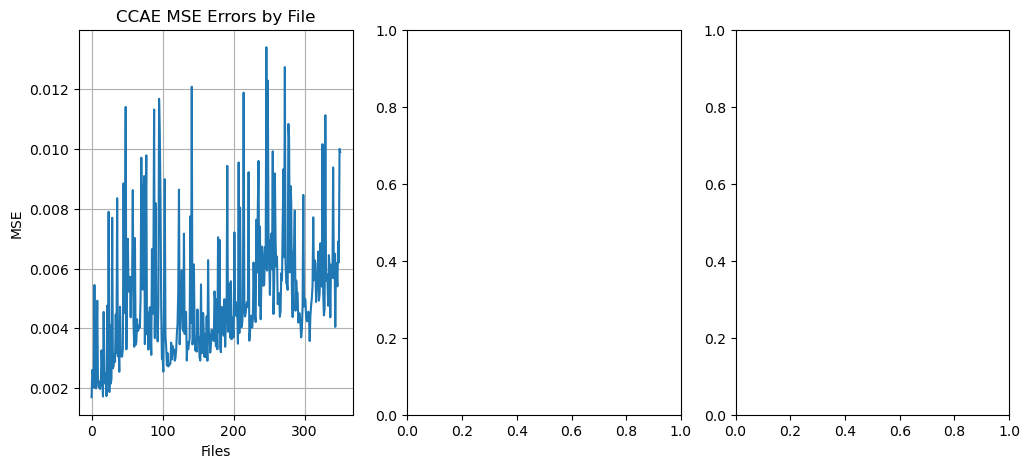

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# 1. MSE Errors by File
axs[0].plot(range(len(ccae_result['mse_avg_byfile'])), ccae_result['mse_avg_byfile'])
axs[0].set_title('CCAE MSE Errors by File')
axs[0].set_xlabel('Files')
axs[0].set_ylabel('MSE')
axs[0].grid(True)

# 2. First input: original vs reconstructed
first_input = all_inputs[0:1]
first_recon = my_ccae_model_trained.predict([first_input[:, :, 0:1], first_input[:, :, 1:2], np.array([[1]])])
axs[1].plot(first_input[0, :, 0], label='Input Alpha')
axs[1].plot(np.squeeze(first_recon[0][0]), label='Reconstructed Alpha')
axs[1].plot(first_input[0, :, 1], label='Input Beta')
axs[1].plot(np.squeeze(first_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[1].plot(first_input[0, :, 0] - np.squeeze(first_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[1].plot(first_input[0, :, 1] - np.squeeze(first_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[1].set_title('First Input: Original vs Reconstructed')
axs[1].legend()
axs[1].grid(True)

# 3. Last input: original vs reconstructed
last_input = all_inputs[-1:]
last_recon = my_ccae_model_trained.predict([last_input[:, :, 0:1], last_input[:, :, 1:2], np.array([[1]])])
axs[2].plot(last_input[0, :, 0], label='Input Alpha')
axs[2].plot(np.squeeze(last_recon[0][0]), label='Reconstructed Alpha')
axs[2].plot(last_input[0, :, 1], label='Input Beta')
axs[2].plot(np.squeeze(last_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[2].plot(last_input[0, :, 0] - np.squeeze(last_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[2].plot(last_input[0, :, 1] - np.squeeze(last_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[2].set_title('Last Input: Original vs Reconstructed')
axs[2].legend()
axs[2].grid(True)

# 統一第二、三張圖的 y 軸範圍
ymin = min(axs[1].get_ylim()[0], axs[2].get_ylim()[0])
ymax = max(axs[1].get_ylim()[1], axs[2].get_ylim()[1])
axs[1].set_ylim(ymin, ymax)
axs[2].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## 比較不同模型的 RUL ##

ValueError: in user code:

    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "CCAE_model4_in_4_out" expects 5 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=int32>]


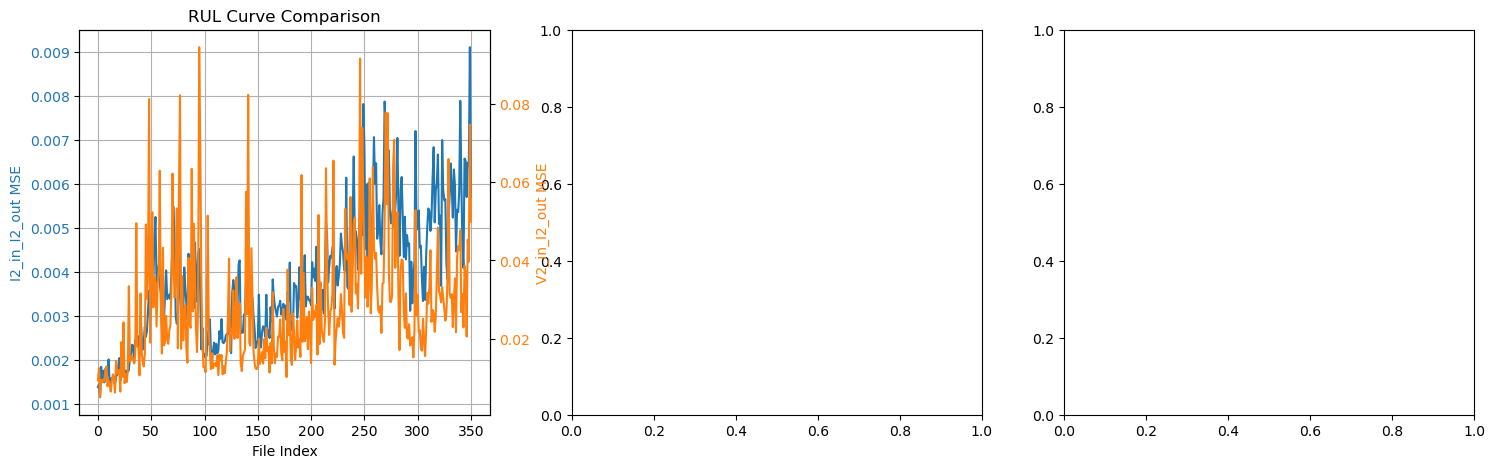

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. RUL Curve Comparison
color1 = 'tab:blue'
color2 = 'tab:orange'
ax1.set_xlabel('File Index')
ax1.set_ylabel('I2_in_I2_out MSE', color=color1)
ax1.plot(range(len(I2_in_I2_out_apply_result['mse_avg_byfile'])), I2_in_I2_out_apply_result['mse_avg_byfile'], label='I2_in_I2_out', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax1b = ax1.twinx()
ax1b.set_ylabel('V2_in_I2_out MSE', color=color2)
ax1b.plot(range(len(V2_in_I2_out_apply_result['mse_avg_byfile'])), V2_in_I2_out_apply_result['mse_avg_byfile'], label='V2_in_I2_out', color=color2)
ax1b.tick_params(axis='y', labelcolor=color2)
ax1.set_title('RUL Curve Comparison')

# 2. I2_in_I2_out 第一個切片
first_input_i2 = I2_in_I2_out_apply_result['all_inputs'][0:1, :, 2:4]  # (1, 1024, 2)
first_recon_i2 = my_ccae_model_trained.predict([first_input_i2[:, :, 0:1], first_input_i2[:, :, 1:2], np.array([[1]])])
ax2.plot(first_input_i2[0, :, 0], label='Input Alpha')
ax2.plot(np.squeeze(first_recon_i2[0][0]), label='Reconstructed Alpha')
ax2.plot(first_input_i2[0, :, 1], label='Input Beta')
ax2.plot(np.squeeze(first_recon_i2[1][0]), label='Reconstructed Beta')
ax2.set_title('I2_in_I2_out: First Slice')
ax2.legend()
ax2.grid(True)

# 3. V2_in_I2_out 第一個切片
first_input_v2 = V2_in_I2_out_apply_result['all_inputs'][0:1, :, :2]  # (1, 1024, 2)
first_recon_v2 = my_ccae_model_trained.predict([first_input_v2[:, :, 0:1], first_input_v2[:, :, 1:2], np.array([[1]])])
# 目標是重建 Ialpha, Ibeta
target_i = V2_in_I2_out_apply_result['all_inputs'][0:1, :, 2:4]
ax3.plot(target_i[0, :, 0], label='Target Alpha')
ax3.plot(np.squeeze(first_recon_v2[0][0]), label='Reconstructed Alpha')
ax3.plot(target_i[0, :, 1], label='Target Beta')
ax3.plot(np.squeeze(first_recon_v2[1][0]), label='Reconstructed Beta')
ax3.set_title('V2_in_I2_out: First Slice')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


# 檢視重建結果 #

In [ ]:
verify_results = my_ccae_model_trained.predict([train_input_signals[0:1,:,0:1], train_input_signals[0:1,:,1:2] , np.array([[1]]) ])
plt.figure()
plt.title('CCAE Reconstructed Signals')
plt.plot(train_input_signals[0,:,0], label='Input Alpha')
plt.plot(np.squeeze(np.array(verify_results[0])), label='Reconstructed Alpha')

In [ ]:
print(model_input_signas)  # 檢查第一個檔案的結果形狀

In [ ]:
# 根據 my_ccae_objects 的數量動態產生 (n, 1) 的 subplot
n = len(my_ccae_objects)
fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)

if n == 1:
    axes = [axes]  # 保證 axes 可迭代

for idx, (my_ccae, ax) in enumerate(zip(my_ccae_objects, axes)):
    ax.plot(my_ccae.basic_timelist["Time stamps"], my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    ax.set_ylabel("MSE Error")
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 0.005)

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [ ]:

# 繪製並重疊每次實驗的 MSE Errors
plt.figure(figsize=(12, 8))
plt.xlabel("Sample Index")
plt.ylabel("MSE Error")
for my_ccae in (my_ccae_objects):
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
             label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show(block=True)
plt.savefig("mse_errors_plot.png")
plt.ylim(0, 0.005)

In [ ]:
for my_ccae in (my_ccae_objects):
    plt.figure(figsize=(12, 8))
    plt.xlabel("Sample Index")
    plt.ylabel("MSE Error")
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show(block=True)